I'm super excited about the [latest release](http://scikit-learn.org/stable/whats_new.html#version-0-20) of scikit-learn (`0.20`) because it contains a new [ColumnTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) class. This class solves an extremely common real world use-case: 

>You have heterogeneous data (e.g. a mix of categorical, real, and integer valued data), and you would like to generate features out of your data using different logic for the different types of data.

Often, people employ a bunch of `apply()` functions on their pandas dataframes in order to handle this scenario. While this may work, it's clunky, a pain to test, and difficult to serialize. Beside, we have scikit-learn [Pipelines](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) now. And if you haven't realized, _everything_ in data science is a pipeline.

This post is quick. I'll walk through a simple case study around using the `ColumnTransformer`. Then, I'll demonstrate how the `ColumnTransformer` allows us to dynamically generate Pipelines from configuration files.

## Case Study

We start by grabbing a generic dataset of bank marketing data from the UCI repository. The actual data isn't really important for this post- all I know is that this is a classification problem with heterogenous data.

In [35]:
import io
import warnings
import zipfile

import altair as alt
import numpy as np
import pandas as pd
import requests
import yaml

In [36]:
def download_extract_zip(url):
    """
    Taken from here https://techoverflow.net/2018/01/16/downloading-reading-a-zip-file-in-memory-using-python/
    
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile

In [37]:
url = ('https://archive.ics.uci.edu/ml/'
       'machine-learning-databases/00222/bank.zip')
files = download_extract_zip(url)

for filename, file_ in files:
    if filename == 'bank-full.csv':
        df = pd.read_csv(file_, sep=';')

In [38]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


As you can see, we have categorical data (like `job`) and real-valued data (like `balance`). As well, the real-valued columns have different distributions.

In [69]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, 
                                   PowerTransformer)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

In [40]:
y = df.pop('y')

In [144]:
one_hot_cols = ['job', 'marital', 'education', 'housing', 'loan',
                'contact', 'month', 'day']
std_cols = ['age']
pow_cols = ['balance', 'duration']
column_transformer = make_column_transformer(
    (one_hot_cols, OneHotEncoder()),
    (std_cols, StandardScaler()),
    (pow_cols, PowerTransformer())
)

pipeline = Pipeline([
    ('col_trans', column_transformer),
    ('log_reg', LogisticRegression())
])


In [145]:
param_grid = {'log_reg__C': [1, 0.1, 0.01, 0.001, 0.0001],
              'log_reg__penalty': ['l1', 'l2']}

search = GridSearchCV(pipeline, param_grid, cv=5,
                      n_jobs=-1, scoring='roc_auc',
                      return_train_score=False)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    search.fit(df, y)

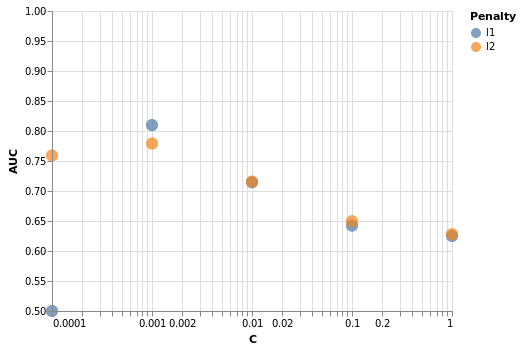

In [147]:
results = pd.DataFrame(search.cv_results_)

chart = alt.Chart(results).mark_circle(size=150).encode(
    alt.X('param_log_reg__C', title='C', scale=alt.Scale(type='log', base=10)),
    alt.Y('mean_test_score', title='AUC', scale=alt.Scale(domain=(0.5, 1.0))),
    alt.Color('param_log_reg__penalty', title='Penalty'),
)
chart

In [110]:
config_file = """
pipeline:
  - path: column_transformer
    args:
      - path: sklearn.preprocessing.OneHotEncoder
        columns: [job, education, housing, loan, contact, month, day]
      - path: sklearn.preprocessing.StandardScaler
        columns: [age]
      - path: sklearn.preprocessing.PowerTransformer
        columns: [balance, duration]
  - path: sklearn.linear_model.LogisticRegression
    kwargs:
      C: 0.001
      penalty: l2
"""
config = yaml.load(io.StringIO(config_file))

In [111]:
import sklearn.preprocessing
import importlib


class PipelineConstructor:
    
    def __init__(self):
        pass
    
    def _instantiate(self, path, *args, **kwargs):
        """
        Import module and instantiate class, given a full path to the class.
        """
        module, klass = path.rsplit('.', maxsplit=1)
        module = importlib.import_module(module)
        return getattr(module, klass)(*args, **kwargs)
    
    def _column_transformer(self, transformers):
        """Create an sklearn ColumnTransformer"""
        transforms = []
        for transformer in transformers:
            transforms.append((transformer['columns'], 
                               self._instantiate(transformer['path'])))
        return make_column_transformer(*transforms)
    
    def construct(self, config):
        """Create an sklearn Pipeline from a configuration file."""
        steps = []
        for step in config['pipeline']:
            if step['path'] == 'column_transformer':
                step = self._column_transformer(step['args'])
            else:
                step = self._instantiate(step['path'], 
                                         *step.get('args', tuple()),
                                         **step.get('kwargs', {}))
            steps.append(step)
        return make_pipeline(*steps)
    
pipeline = PipelineConstructor().construct(config)    

In [109]:
pipeline.fit(df, y)

/home/er/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/er/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/er/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
    ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])